In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./glove.840B.300d.txt
./smartstoplist.txt
./sms-spam-detection-mnb-lstm-gru-bi-lstm.ipynb
./spam.csv
./.ipynb_checkpoints\app-checkpoint.py
./.ipynb_checkpoints\sms-spam-detection-mnb-lstm-gru-bi-lstm-checkpoint.ipynb


# Importing Required Libraries

In [2]:
!pip install scikit-plot



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [4]:
df_ = pd.read_csv("./spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df = df_.copy()
df.columns = ["label", "text"]
df = df[["text", "label"]]
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [6]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [7]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 5572
COLS: 2


**##################### TYPES ######################**

text     object
label     int64
dtype: object


**################# MISSING VALUES #################**

text     0
label    0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 403


**################## MEMORY USAGE ##################**

Memory Usage: 87.2+ KB


In [8]:
df = df.drop_duplicates()

# Exploratory Data Analysis

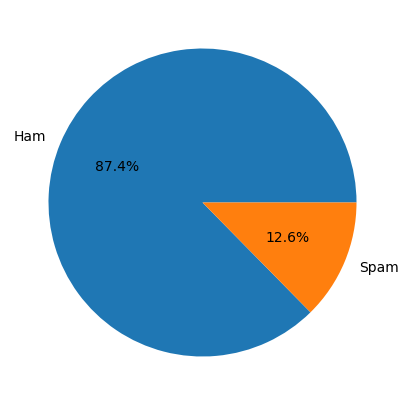

In [9]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Ham", "Spam"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

In [10]:
def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

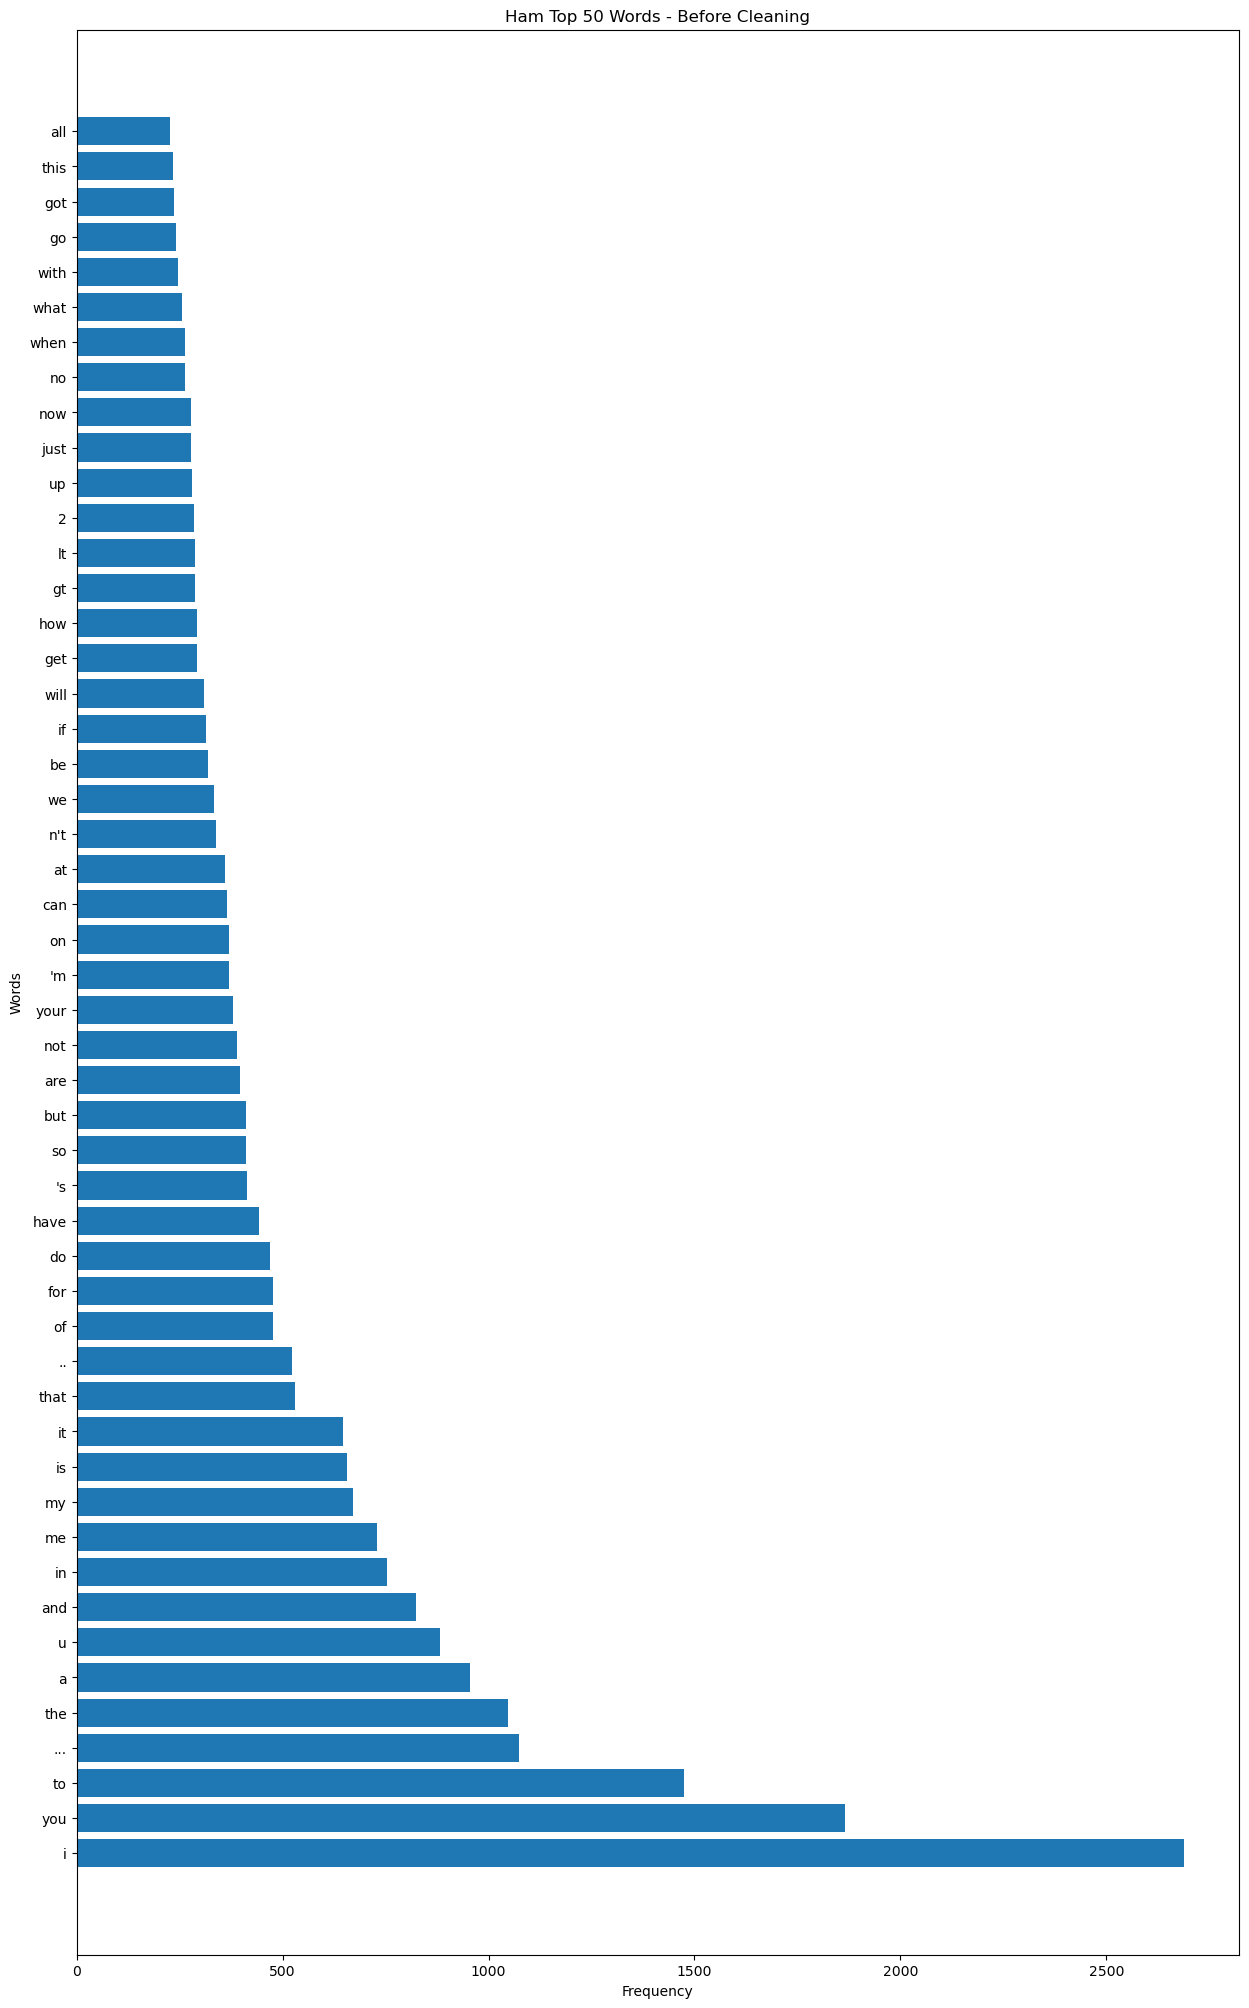

In [11]:
ham_freq_top = word_freq(df, 0, "text", "Ham Top 50 Words - Before Cleaning")

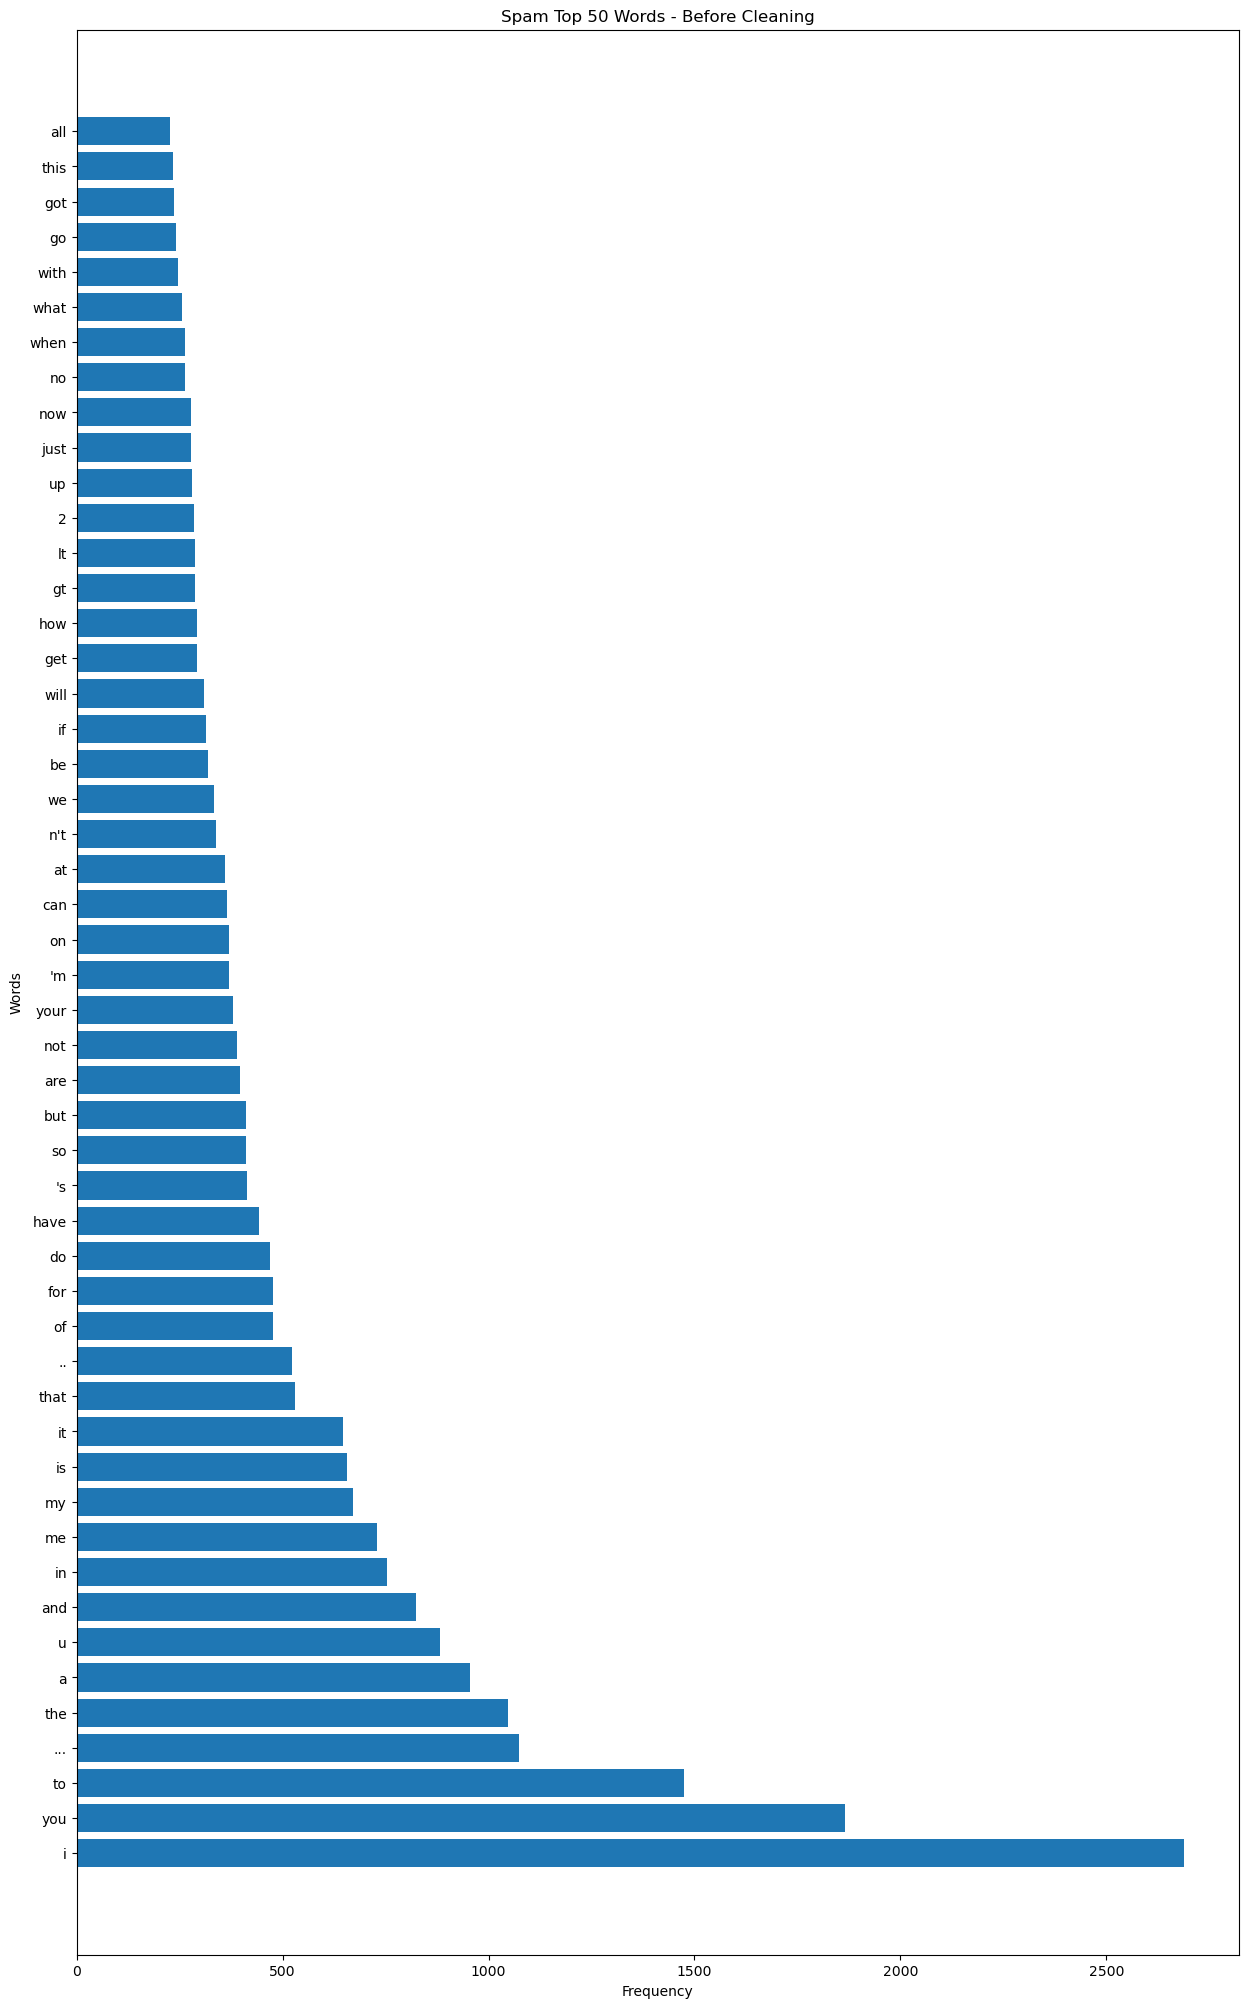

In [12]:
spam_freq_top = word_freq(df, 0, "text", "Spam Top 50 Words - Before Cleaning")

In [13]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

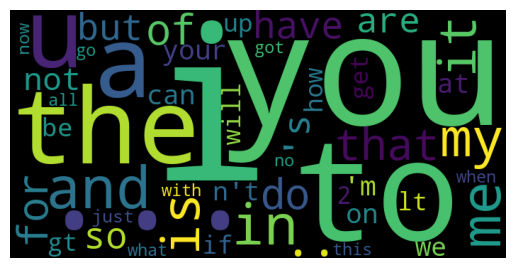

In [14]:
print_wordcloud(ham_freq_top)

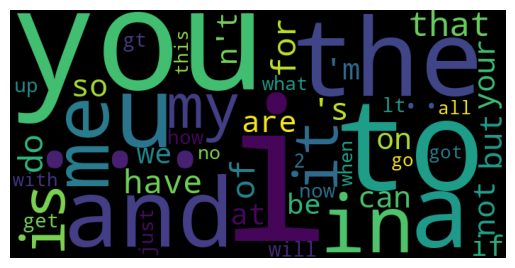

In [15]:
print_wordcloud(spam_freq_top)

# Preprocess

In [16]:
stop_words = set(stopwords.words("english"))

In [17]:
smart_words = "./smartstoplist.txt"

In [18]:
smart_stoplist = []

In [19]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [20]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [21]:
smart_stoplist.append("_")

In [22]:
!ls -l /usr/share/nltk_data/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
#nltk.download("all")
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
df["clean"] = df["text"].apply(clean)

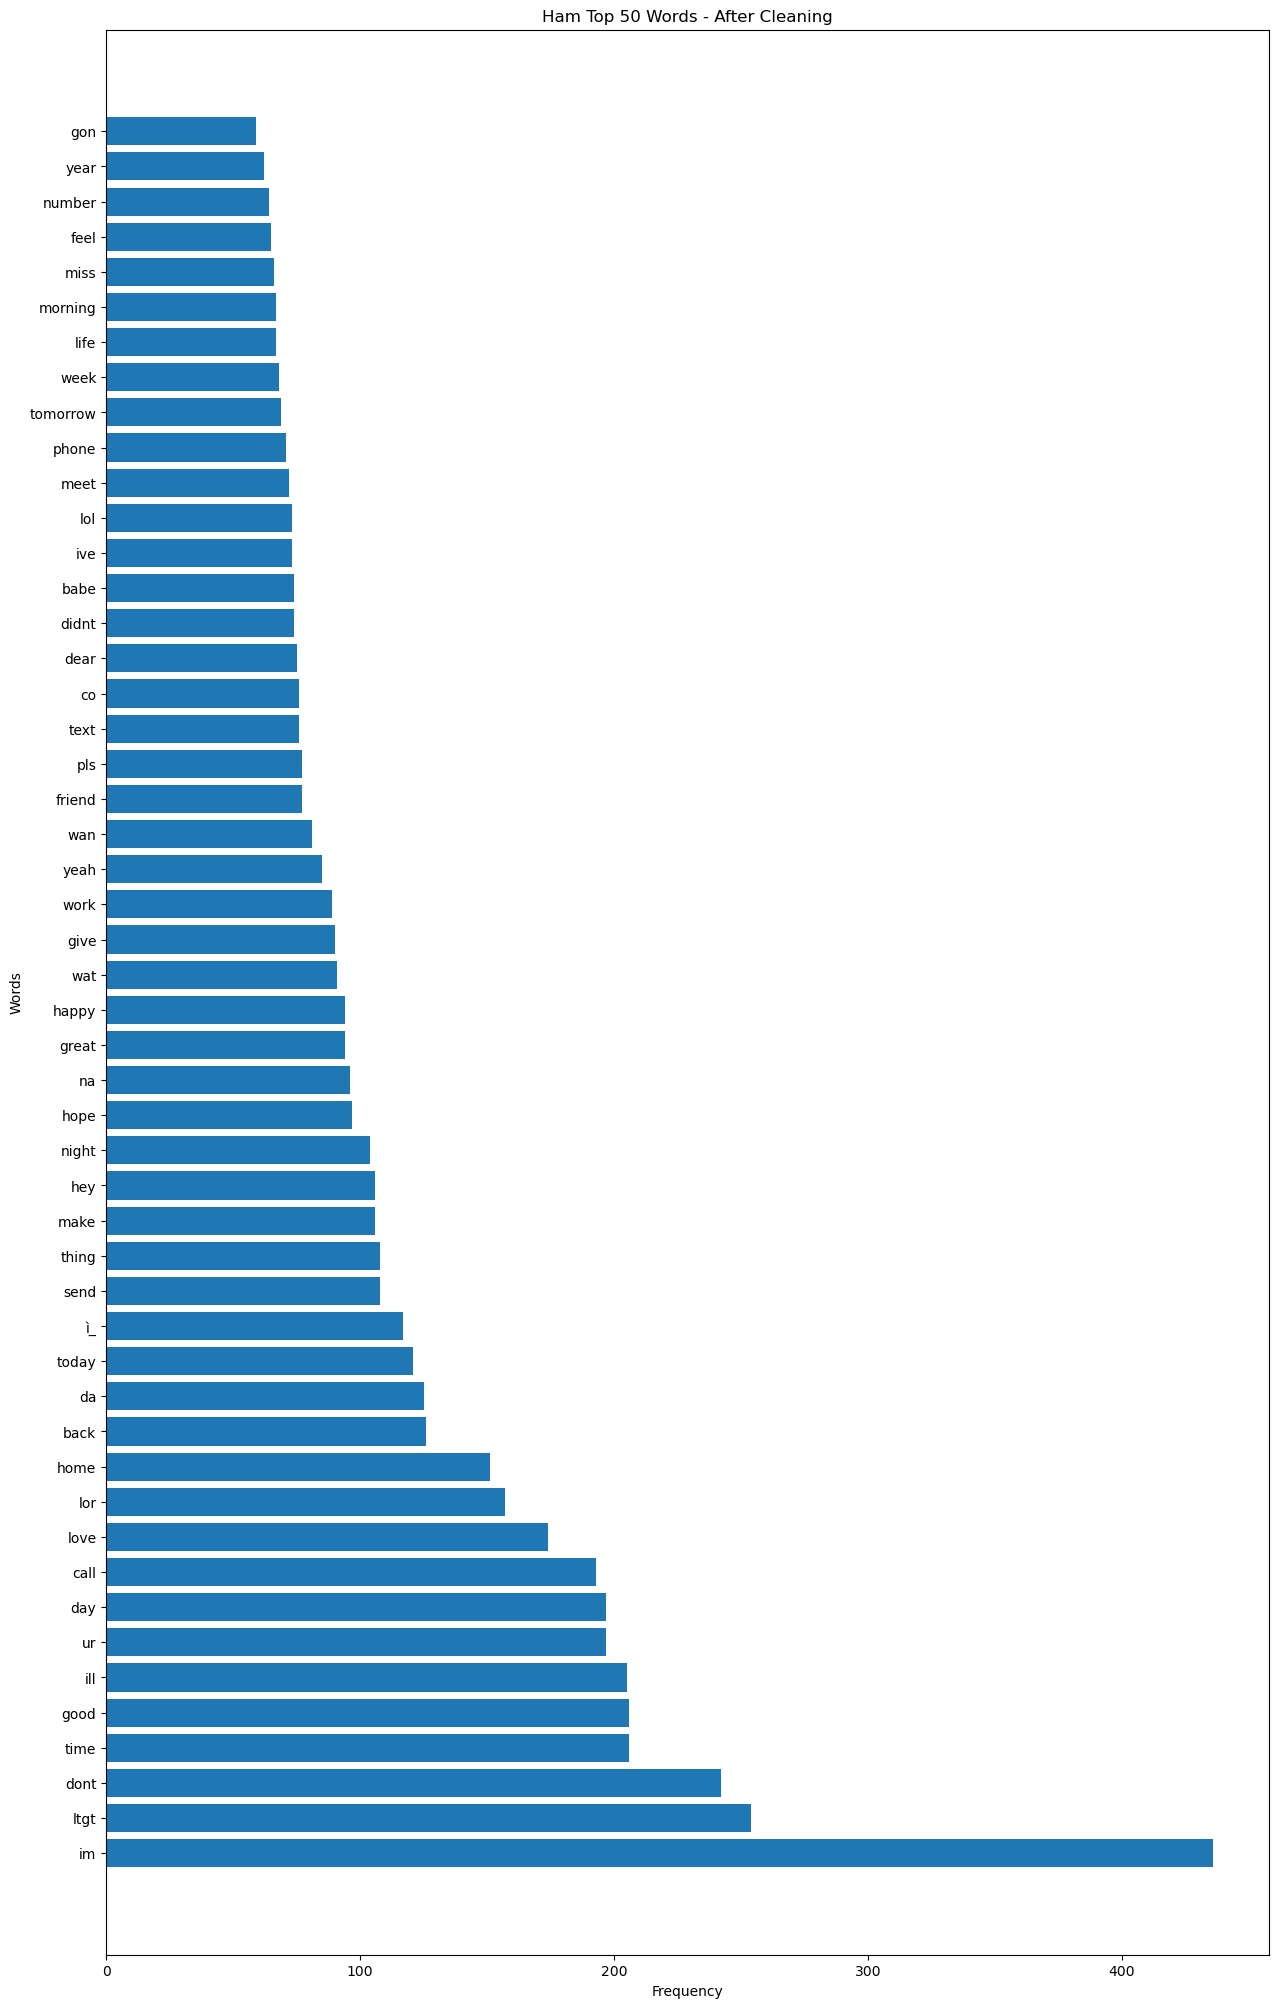

In [25]:
clean_ham_freq_top = word_freq(df, 0, "clean", "Ham Top 50 Words - After Cleaning")

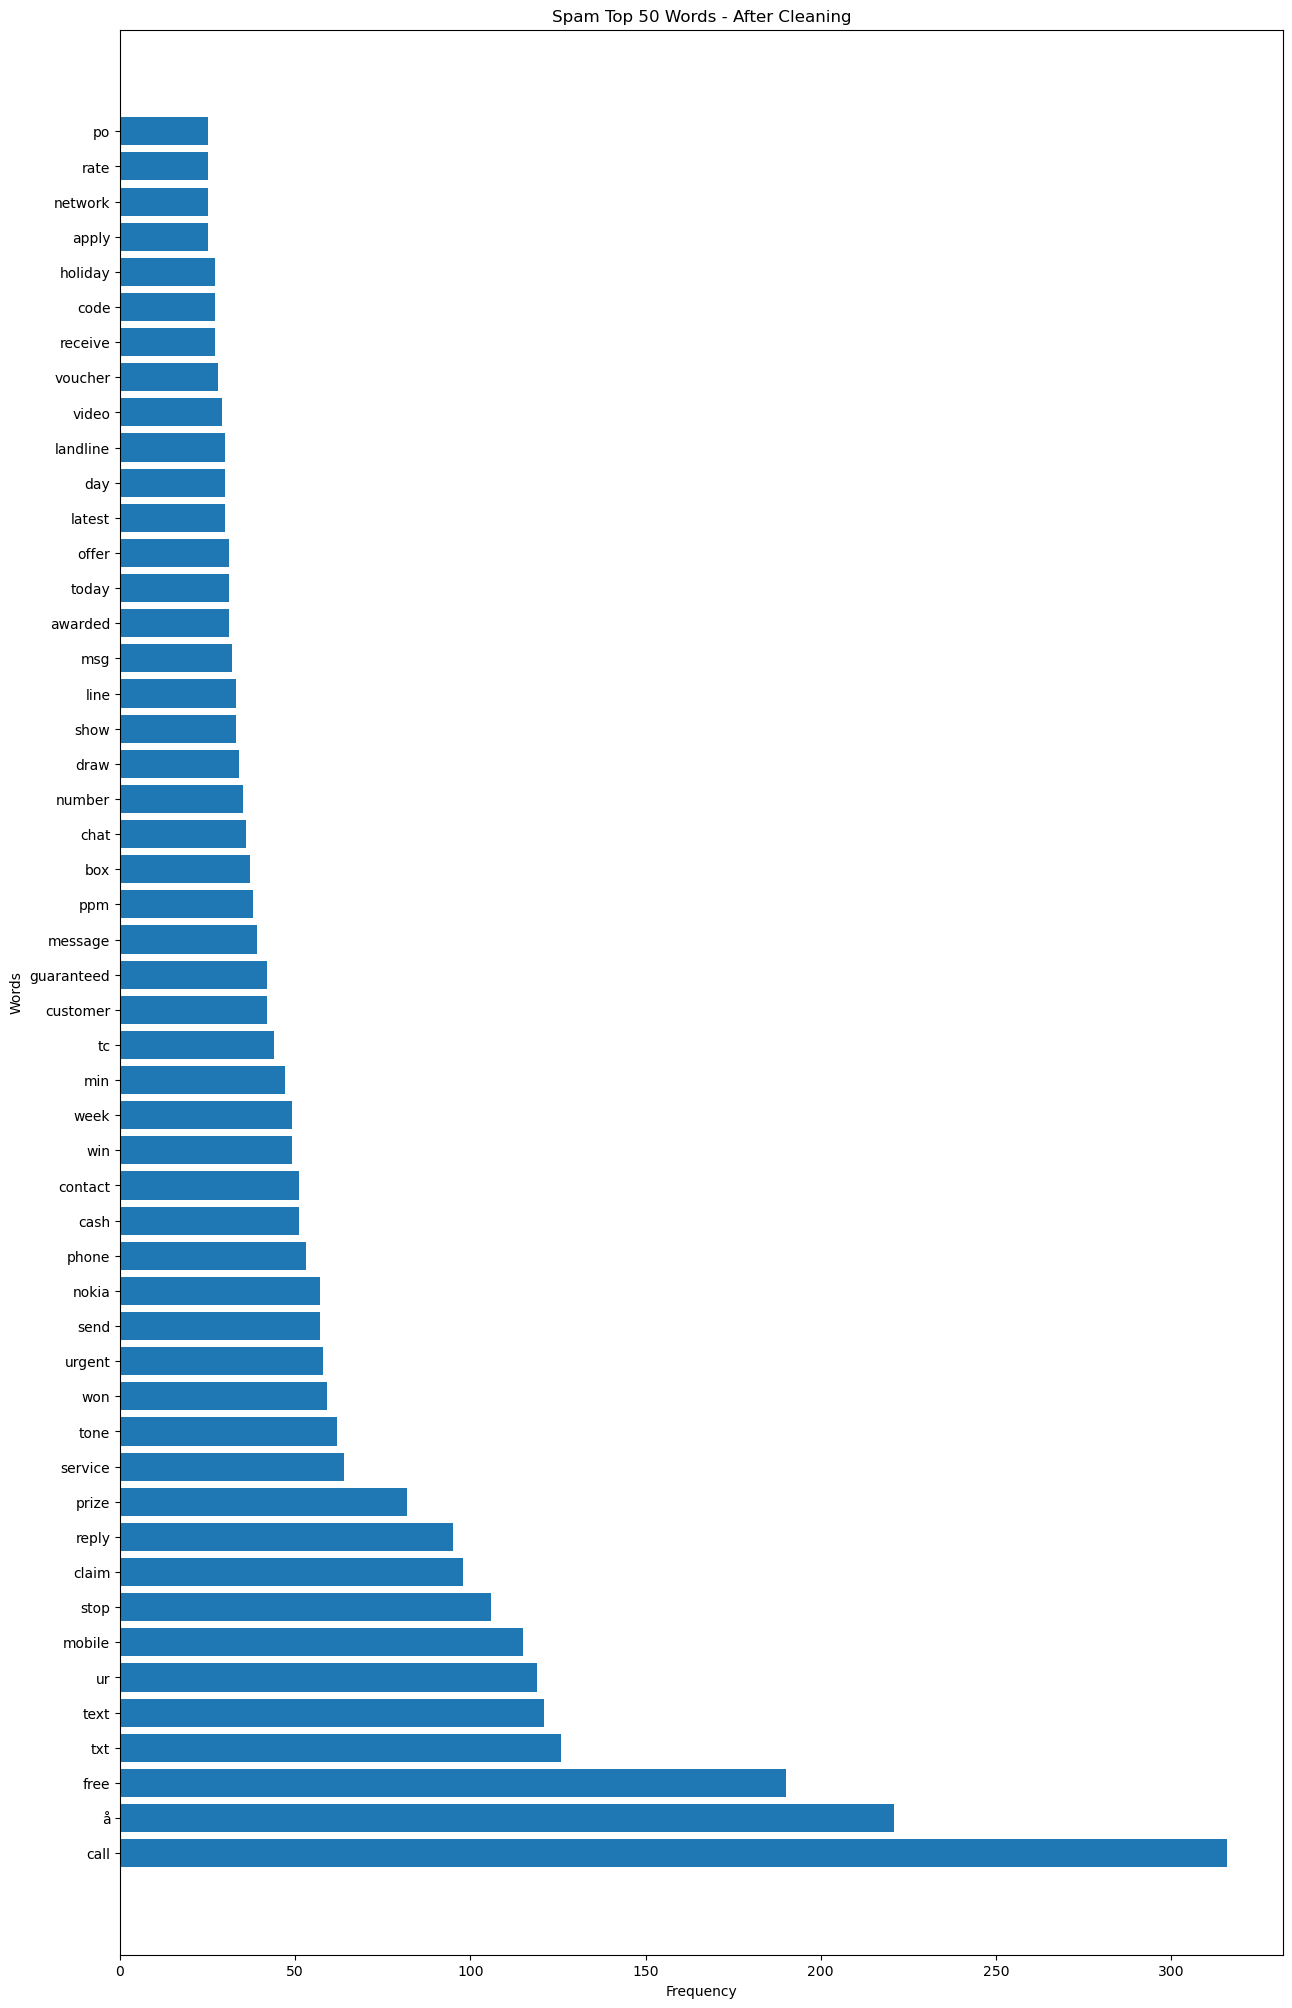

In [26]:
clean_spam_freq_top = word_freq(df, 1, "clean", "Spam Top 50 Words - After Cleaning")

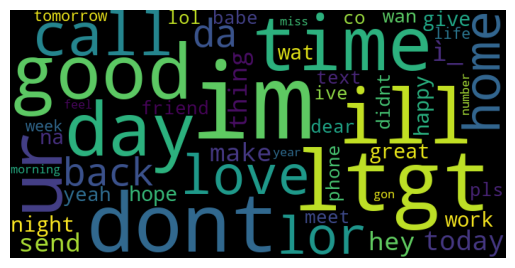

In [27]:
print_wordcloud(clean_ham_freq_top)

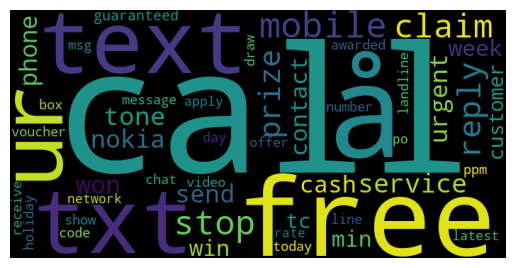

In [28]:
print_wordcloud(clean_spam_freq_top)

# Feature Scaling

In [29]:
X = df["clean"]
y = df["label"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [32]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [33]:
maxlen = 70

In [34]:
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [35]:
word_index = tokenizer.word_index
len(word_index)

7643

In [36]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [37]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [38]:
embeddings_index = {}
f = open("./glove.840B.300d.txt", "r", encoding="utf-8")
for line in tqdm.tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs

f.close()
print("Found %s word vectors." % len(embeddings_index))

2196018it [07:04, 5173.27it/s]

Found 2196017 word vectors.


In [39]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████████| 7643/7643 [00:01<00:00, 4901.83it/s]


# Models

# TFIDF + MultinomialNB

In [40]:
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_end = time.time()
mnb_tfidf_train_time = mnb_tfidf_train_end - mnb_tfidf_train_start
print("TFIDF + MultnomialNB Train Time = ", mnb_tfidf_train_time)

TFIDF + MultnomialNB Train Time =  0.07595658302307129


In [41]:
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_test_start = time.time()
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
mnb_tfidf_test_end = time.time()
mnb_tfidf_test_time = mnb_tfidf_test_end - mnb_tfidf_test_start

mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)
print(f"TFIDF + MultinomialNB Train Score = {mnb_tfidf_train_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Score = {mnb_tfidf_test_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Time = ", mnb_tfidf_test_time)

TFIDF + MultinomialNB Train Score = 97.07%
TFIDF + MultinomialNB Test Score = 95.84%
TFIDF + MultinomialNB Test Time =  0.0012047290802001953


In [42]:
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)

print(f"TFIDF + MultinomialNB Precision Score = {mnb_tfidf_precision_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB F1 Score = {mnb_tfidf_f1_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Recall Score = {mnb_tfidf_recall_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Accuracy Score = {mnb_tfidf_accuracy_score * 100:.2f}%")

TFIDF + MultinomialNB Precision Score = 100.00%
TFIDF + MultinomialNB F1 Score = 82.59%
TFIDF + MultinomialNB Recall Score = 70.34%
TFIDF + MultinomialNB Accuracy Score = 95.84%


In [43]:
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       889
        spam       1.00      0.70      0.83       145

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



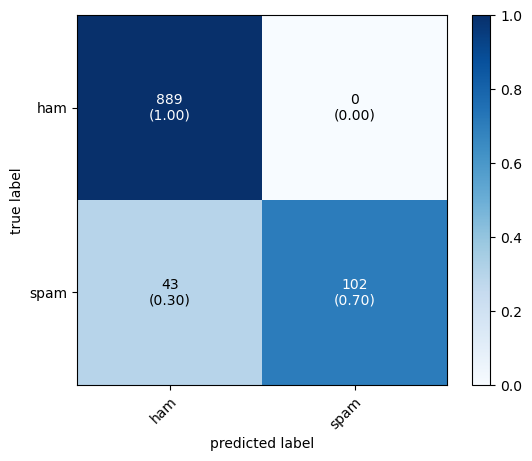

In [44]:
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

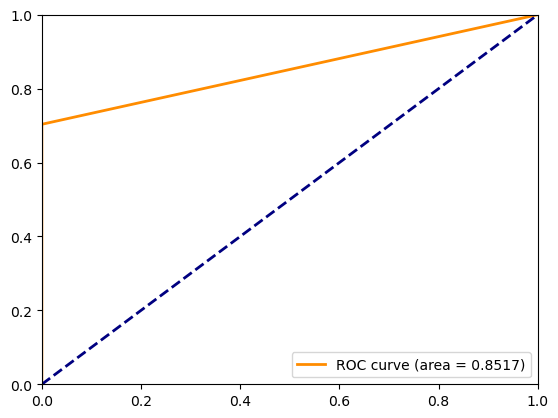

In [45]:
fpr, tpr, _ = roc_curve(y_test, mnb_tfidf_pred_test)
mnb_tfidf_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_tfidf_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# CV + MultinomialNB

In [46]:
mnb = MultinomialNB()
mnb_cv_train_start = time.time()
mnb.fit(X_train_cv, y_train)
mnb_cv_train_end = time.time()
mnb_cv_train_time = mnb_cv_train_end - mnb_cv_train_start
print("CV + MultinomialNB Train Time = ", mnb_cv_train_time)

CV + MultinomialNB Train Time =  0.006434440612792969


In [47]:
mnb_cv_pred_train = mnb.predict(X_train_cv)
mnb_cv_test_start = time.time()
mnb_cv_pred_test = mnb.predict(X_test_cv)
mnb_cv_test_end = time.time()
mnb_cv_test_time = mnb_cv_test_end - mnb_cv_test_start

mnb_cv_train_score = accuracy_score(mnb_cv_pred_train, y_train)
mnb_cv_test_score = accuracy_score(mnb_cv_pred_test, y_test)
print(f"CV + MultinomialNB Train Score = {mnb_cv_train_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Score = {mnb_cv_test_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Time = ", mnb_cv_test_time)

CV + MultinomialNB Train Score = 98.96%
CV + MultinomialNB Test Score = 97.68%
CV + MultinomialNB Test Time =  0.0029900074005126953


In [48]:
mnb_cv_precision_score = precision_score(y_test, mnb_cv_pred_test)
mnb_cv_f1_score = f1_score(y_test, mnb_cv_pred_test)
mnb_cv_recall_score = recall_score(y_test, mnb_cv_pred_test)
mnb_cv_accuracy_score = accuracy_score(y_test, mnb_cv_pred_test)

print(f"CV + MultinomialNB Precision Score = {mnb_cv_precision_score * 100:.2f}%")
print(f"CV + MultinomialNB F1 Score = {mnb_cv_f1_score * 100:.2f}%")
print(f"CV + MultinomialNB Recall Score = {mnb_cv_recall_score * 100:.2f}%")
print(f"CV + MultinomialNB Accuracy Score = {mnb_cv_accuracy_score * 100:.2f}%")

CV + MultinomialNB Precision Score = 94.16%
CV + MultinomialNB F1 Score = 91.49%
CV + MultinomialNB Recall Score = 88.97%
CV + MultinomialNB Accuracy Score = 97.68%


In [49]:
print(classification_report(y_test, mnb_cv_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.94      0.89      0.91       145

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



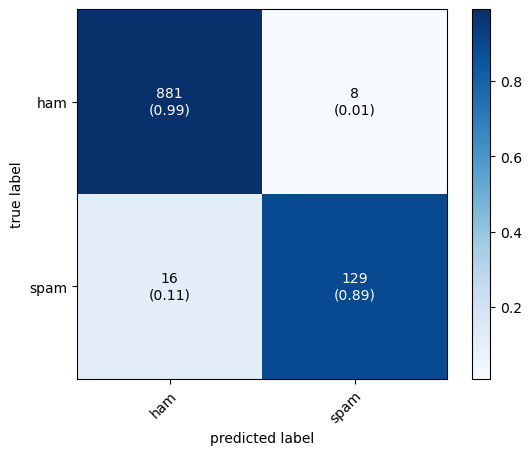

In [50]:
mnb_cv_cm = confusion_matrix(y_test, mnb_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_cv_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

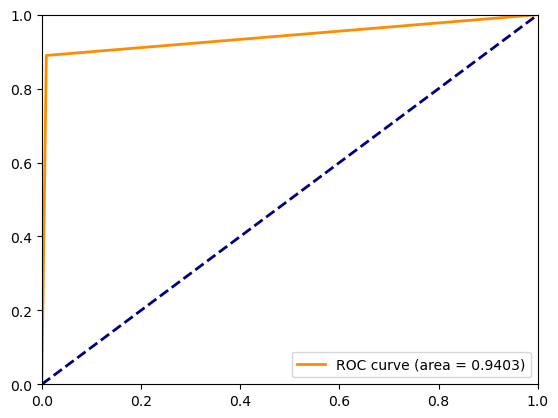

In [51]:
fpr, tpr, _ = roc_curve(y_test, mnb_cv_pred_test)
mnb_cv_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_cv_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# SimpleRNN

In [52]:
from keras.models import Sequential
from keras.layers import Input, Embedding, SimpleRNN, Dense

# Assuming X_train_tokenizer.shape[1] represents the input_shape 70
input_shape = X_train_tokenizer.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

print(input_shape)

# Create a Sequential model
simplernn = Sequential()

# Add layers
simplernn.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
simplernn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape))

# Initialize the Embedding layer with pre-trained word embeddings
simplernn.layers[0].set_weights([embedding_matrix])  # Set weights to the first layer
simplernn.layers[0].trainable = False  # Make the Embedding layer non-trainable

simplernn.add(SimpleRNN(100))
simplernn.add(Dense(1, activation='sigmoid'))

# Compile the model
simplernn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
simplernn.summary()


70


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,333,401 (8.90 MB)

 Trainable params: 40,201 (157.04 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [53]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8631 - loss: 0.2952 - val_accuracy: 0.9638 - val_loss: 0.0973
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9754 - loss: 0.0814 - val_accuracy: 0.9831 - val_loss: 0.0651
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9753 - loss: 0.0785 - val_accuracy: 0.9855 - val_loss: 0.0552
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9881 - loss: 0.0440 - val_accuracy: 0.9710 - val_loss: 0.1033
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9939 - loss: 0.0284 - val_accuracy: 0.9783 - val_loss: 0.0642
Model1 Train Time =  15.354350805282593


In [54]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Model1 Test Time =  1.2833364009857178


In [55]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
SimpleRNN Train Score = 99.35%
SimpleRNN Test Score = 98.07%


In [56]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 93.71%
SimpleRNN F1 Score = 93.06%
SimpleRNN Recall Score = 92.41%
SimpleRNN Accuracy Score = 98.07%


In [57]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       889
        spam       0.94      0.92      0.93       145

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



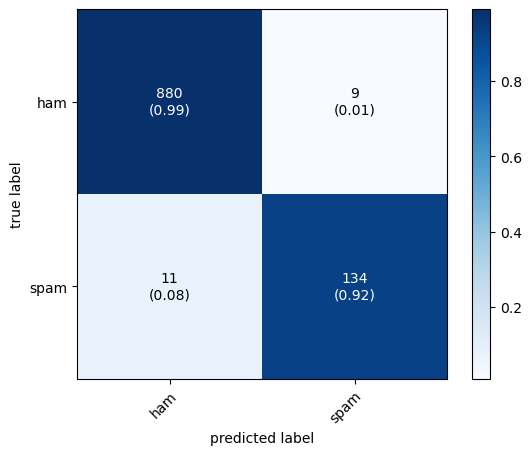

In [58]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

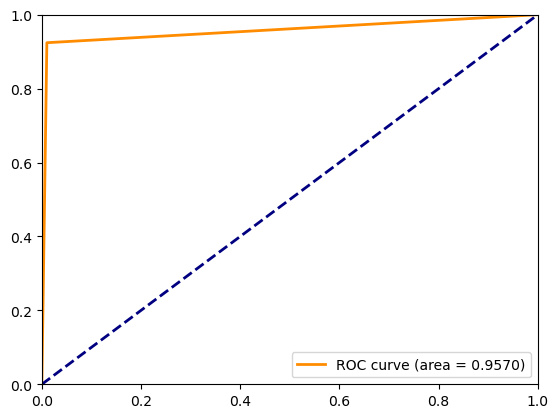

In [59]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# LSTM

In [60]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
lstm = Sequential()

# Add layers
lstm.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
lstm.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
lstm.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
lstm.layers[0].trainable = False  # Make the Embedding layer non-trainable

lstm.add(LSTM(100))
lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,453,701 (9.36 MB)

 Trainable params: 160,501 (626.96 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [61]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.8729 - loss: 0.3359 - val_accuracy: 0.9758 - val_loss: 0.0722
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9688 - loss: 0.0912 - val_accuracy: 0.9903 - val_loss: 0.0456
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.9814 - loss: 0.0579 - val_accuracy: 0.9831 - val_loss: 0.0449
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9910 - loss: 0.0355 - val_accuracy: 0.9807 - val_loss: 0.0516
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9892 - loss: 0.0359 - val_accuracy: 0.9903 - val_loss: 0.0334
Model2 Train Time =  37.6981840133667


In [62]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Model2 Test Time =  2.0051634311676025


In [63]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
LSTM Train Score = 99.35%
LSTM Test Score = 97.97%


In [64]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 94.93%
LSTM F1 Score = 92.58%
LSTM Recall Score = 90.34%
LSTM Accuracy Score = 97.97%


In [65]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.95      0.90      0.93       145

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



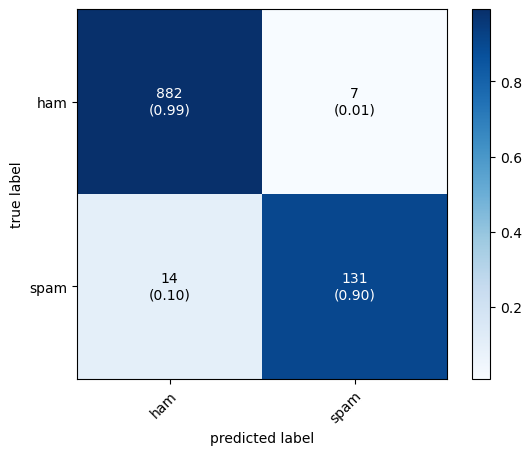

In [66]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

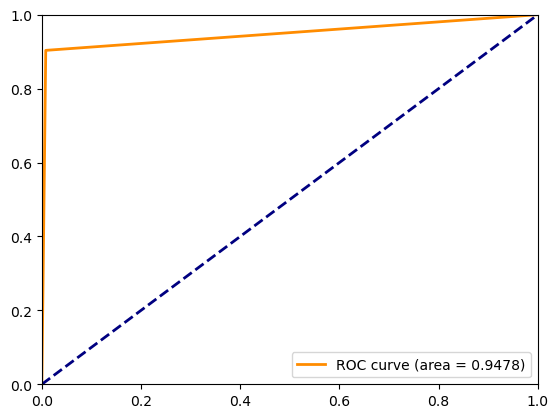

In [67]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# GRU

In [68]:
from keras.models import Sequential
from keras.layers import Input, Embedding, GRU, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
gru = Sequential()

# Add layers
gru.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
gru.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
gru.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
gru.layers[0].trainable = False  # Make the Embedding layer non-trainable

gru.add(GRU(100))
gru.add(Dense(1, activation='sigmoid'))

# Compile the model
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
gru.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100)                 │         120,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,413,901 (9.21 MB)

 Trainable params: 120,701 (471.49 KB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [69]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.8564 - loss: 0.3385 - val_accuracy: 0.9783 - val_loss: 0.0823
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9691 - loss: 0.0969 - val_accuracy: 0.9903 - val_loss: 0.0472
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9831 - loss: 0.0593 - val_accuracy: 0.9903 - val_loss: 0.0391
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.9889 - loss: 0.0441 - val_accuracy: 0.9928 - val_loss: 0.0313
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9932 - loss: 0.0291 - val_accuracy: 0.9879 - val_loss: 0.0370
Model3 Train Time =  36.699451208114624


In [70]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Model3 Test Time =  2.4900500774383545


In [71]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
GRU Train Score = 99.44%
GRU Test Score = 97.29%


In [72]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 90.34%
GRU F1 Score = 90.34%
GRU Recall Score = 90.34%
GRU Accuracy Score = 97.29%


In [73]:
print(classification_report(y_test, gru_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       889
        spam       0.90      0.90      0.90       145

    accuracy                           0.97      1034
   macro avg       0.94      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034



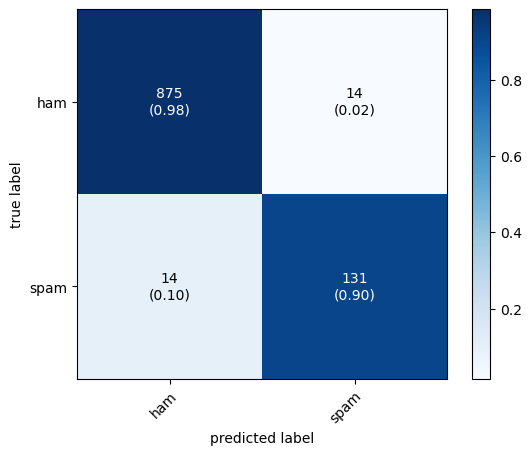

In [74]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

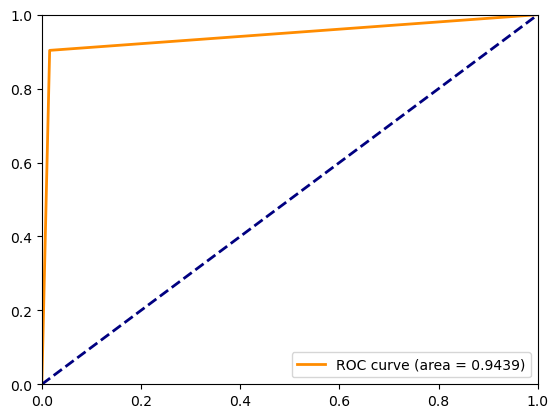

In [75]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Bi-LSTM

In [76]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense

# Assuming X_train_tokenizer.shape[1] represents the input shape
input_shape = X_train_tokenizer.shape[1]

# Create a Sequential model
bilstm = Sequential()

# Add layers
bilstm.add(Input(shape=(input_shape,)))  # Explicit input layer

# Add Embedding layer without weights
bilstm.add(Embedding(len(tokenizer.word_index) + 1, 300))

# Initialize the Embedding layer with pre-trained word embeddings
bilstm.layers[0].set_weights([embedding_matrix])  # Set weights to the second layer
bilstm.layers[0].trainable = False  # Make the Embedding layer non-trainable

bilstm.add(Bidirectional(LSTM(100, return_sequences=True)))
bilstm.add(GlobalMaxPooling1D())
bilstm.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
bilstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 70, 300)             │       2,293,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 70, 200)             │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,614,201 (9.97 MB)

 Trainable params: 321,001 (1.22 MB)

 Non-trainable params: 2,293,200 (8.75 MB)

In [77]:
model4_train_start = time.time()
bilstm_results = bilstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model4_train_end = time.time()
model4_train_time = model4_train_end - model4_train_start
print("Model4 Train Time = ", model4_train_time)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9059 - loss: 0.3320 - val_accuracy: 0.9734 - val_loss: 0.0985
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9705 - loss: 0.0999 - val_accuracy: 0.9831 - val_loss: 0.0940
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9766 - loss: 0.0822 - val_accuracy: 0.9831 - val_loss: 0.0524
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9788 - loss: 0.0612 - val_accuracy: 0.9807 - val_loss: 0.0640
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9853 - loss: 0.0558 - val_accuracy: 0.9807 - val_loss: 0.0459
Model4 Train Time =  46.353190422058105


In [78]:
model4_test_start = time.time()
bilstm_pred_test = bilstm.predict(X_test_tokenizer)
model4_test_end = time.time()
model4_test_time = model4_test_end - model4_test_start
print("Model4 Test Time = ", model4_test_time)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Model4 Test Time =  3.061973810195923


In [79]:
bilstm_pred_train = bilstm.predict(X_train_tokenizer)
bilstm_pred_train = [1 if i > 0.5 else 0 for i in bilstm_pred_train]
bilstm_pred_test = [1 if i > 0.5 else 0 for i in bilstm_pred_test]
bilstm_train_score = accuracy_score(bilstm_pred_train, y_train)
bilstm_test_score = accuracy_score(bilstm_pred_test, y_test)
print(f"BILSTM Train Score = {bilstm_train_score * 100:.2f}%")
print(f"BILSTM Test Score = {bilstm_test_score * 100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
BILSTM Train Score = 99.20%
BILSTM Test Score = 97.87%


In [80]:
bilstm_precision_score = precision_score(y_test, bilstm_pred_test)
bilstm_f1_score = f1_score(y_test, bilstm_pred_test)
bilstm_recall_score = recall_score(y_test, bilstm_pred_test)
bilstm_accuracy_score = accuracy_score(y_test, bilstm_pred_test)

print(f"BILSTM Precision Score = {bilstm_precision_score * 100:.2f}%")
print(f"BILSTM F1 Score = {bilstm_f1_score * 100:.2f}%")
print(f"BILSTM Recall Score = {bilstm_recall_score * 100:.2f}%")
print(f"BILSTM Accuracy Score = {bilstm_accuracy_score * 100:.2f}%")

BILSTM Precision Score = 94.24%
BILSTM F1 Score = 92.25%
BILSTM Recall Score = 90.34%
BILSTM Accuracy Score = 97.87%


In [81]:
print(classification_report(y_test, bilstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.94      0.90      0.92       145

    accuracy                           0.98      1034
   macro avg       0.96      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



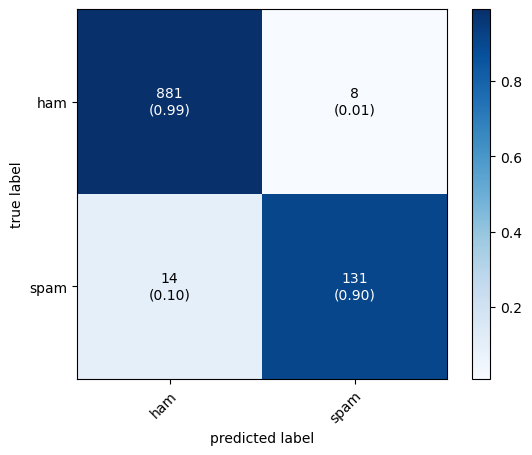

In [82]:
bilstm_cm = confusion_matrix(y_test, bilstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bilstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

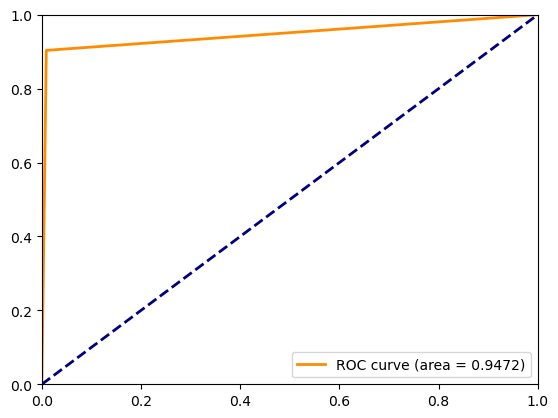

In [83]:
fpr, tpr, _ = roc_curve(y_test, bilstm_pred_test)
bilstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bilstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Results

In [84]:
scores_df = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [85]:
scores_df.loc[0] = ["MultinomialNB + TFIDF",
                    mnb_tfidf_train_time,
                    mnb_tfidf_test_time,
                    mnb_tfidf_train_score,
                    mnb_tfidf_test_score,
                    mnb_tfidf_accuracy_score,
                    mnb_tfidf_f1_score,
                    mnb_tfidf_precision_score,
                    mnb_tfidf_recall_score,
                    mnb_tfidf_roc_auc]

In [86]:
scores_df.loc[1] = ["MultinomialNB + CountVectorizer",
                    mnb_cv_train_time,
                    mnb_cv_test_time,
                    mnb_cv_train_score,
                    mnb_cv_test_score,
                    mnb_cv_accuracy_score,
                    mnb_cv_f1_score,
                    mnb_cv_precision_score,
                    mnb_cv_recall_score,
                    mnb_cv_roc_auc]

In [87]:
scores_df.loc[2] = ["SimpleRNN + GloVe",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [88]:
scores_df.loc[3] = ["LSTM + GloVe",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [89]:
scores_df.loc[4] = ["GRU + GloVe",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [90]:
scores_df.loc[5] = ["Bi-LSTM + GloVe",
                    model4_train_time,
                    model4_test_time,
                    bilstm_train_score,
                    bilstm_test_score,
                    bilstm_accuracy_score,
                    bilstm_f1_score,
                    bilstm_precision_score,
                    bilstm_recall_score,
                    bilstm_roc_auc]

In [91]:
scores_df

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
0,MultinomialNB + TFIDF,0.075957,0.001205,0.970738,0.958414,0.958414,0.825911,1.000000,0.703448,0.851724
1,MultinomialNB + CountVectorizer,0.006434,0.002990,0.989601,0.976789,0.976789,0.914894,0.941606,0.889655,0.940328
2,SimpleRNN + GloVe,15.354351,1.283336,0.993470,0.980658,0.980658,0.930556,0.937063,0.924138,0.957007
3,LSTM + GloVe,37.698184,2.005163,0.993470,0.979691,0.979691,0.925795,0.949275,0.903448,0.947787
4,GRU + GloVe,36.699451,2.490050,0.994438,0.972921,0.972921,0.903448,0.903448,0.903448,0.943850
5,Bi-LSTM + GloVe,46.353190,3.061974,0.992019,0.978723,0.978723,0.922535,0.942446,0.903448,0.947225


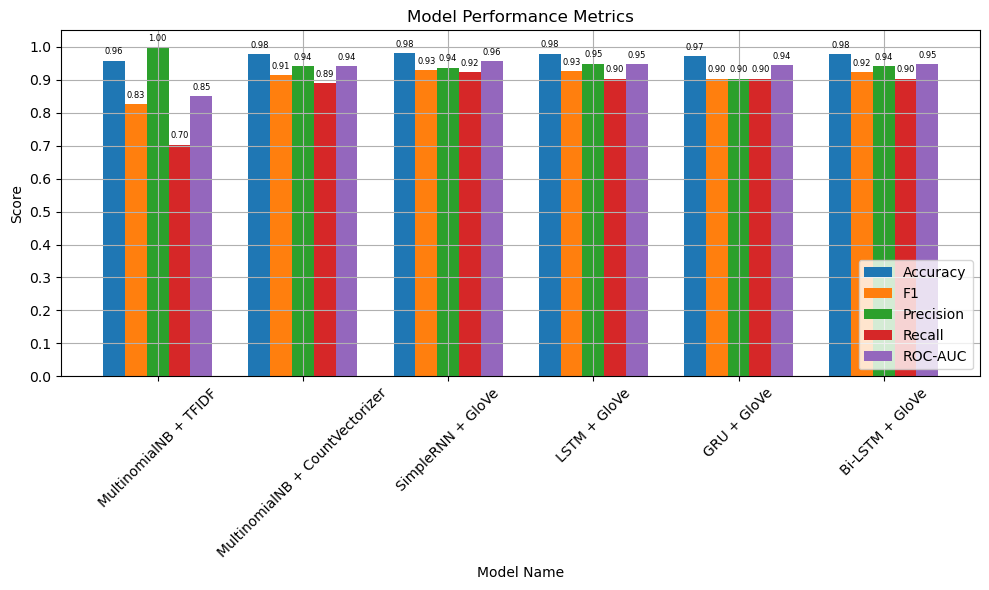

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the performance metrics for each model
metrics = ["Accuracy", "F1", "Precision", "Recall", "ROC-AUC"]
models = scores_df["Model Name"]

# Set the width of the bars
bar_width = 0.15

# Define the positions for the bars
positions = range(len(models))

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric as a histogram
for i, metric in enumerate(metrics):
    bars = ax.bar([p + i * bar_width for p in positions], scores_df[metric], bar_width, label=metric)
    # Add value on each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)  # Set font size to 6

# Add labels and title
ax.set_xlabel('Model Name')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks([p + 2 * bar_width for p in positions])
ax.set_xticklabels(models, rotation=45)

# Set y-axis ticks with a difference of 0.1
ax.set_yticks([i/10 for i in range(11)])

# Move the legend to the bottom right corner
ax.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [468]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Ensure these nltk downloads are only called once
nltk.download('punkt')
nltk.download('stopwords')

def transform_text(text):
    ps = PorterStemmer()
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)

def predict_spam_or_ham(messages):
    transformed_messages = [transform_text(message) for message in messages]
    tokenized_messages = tokenizer.texts_to_sequences(transformed_messages)
    padded_messages = pad_sequences(tokenized_messages, maxlen=input_shape, padding='post')
    results = bilstm.predict(padded_messages)
    print(results)
    return results

# List of demo messages
demo_messages = [
    "Congratulations! You've been selected as a winner of our special promotion. Claim your prize now!",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "good morning",
    "hello, where are you",
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged"
]

# Predict for all messages
predictions = predict_spam_or_ham(demo_messages)

# Print predictions
for i, message in enumerate(demo_messages):
    print(f"Message{i + 1}: {message}")
    print(f"Prediction: {'Spam' if predictions[i][0] > 0.5 else 'Ham'} (Confidence: {predictions[i][0]:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.90696406]
 [0.91148067]
 [0.00538605]
 [0.02682421]
 [0.01668527]
 [0.7005317 ]]
Message1: Congratulations! You've been selected as a winner of our special promotion. Claim your prize now!
Prediction: Spam (Confidence: 0.91)

Message2: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Prediction: Spam (Confidence: 0.91)

Message3: good morning
Prediction: Ham (Confidence: 0.01)

Message4: hello, where are you
Prediction: Ham (Confidence: 0.03)

Message5: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Prediction: Ham (Confidence: 0.02)

Message6: Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged
Prediction: Spam (Confidence: 0.70)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rhit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
